In [1]:
## Created: 6/9/22
## last edited: 6/9/22
## Status: I just found nc files for in situ data on the noaa website, maybe this data will be easier to work with?
##         It's at least worth looking at if it matches with the text file data!

In [3]:
# import packages and plotting scripts

import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import warnings
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from scipy.signal import find_peaks

os.chdir(  "/Users/etmu9498/research/code/scripts")
import make_plots

In [4]:
# view datasets

# paths to data
flight_path = "/Users/etmu9498/research/data/in-situ/nc-files"
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"

crl_list = make_plots.load_crl(crl_path)
flight_list = make_plots.load_flight_level( flight_path )

crl data files:
0) P3_20210811H1_200000-224759.cdf
1) P3_20210812H1_095513-125927.cdf
2) P3_20210812H2_212248-235510.cdf
3) P3_20210813H1_091801-113558.cdf
4) P3_20210816H1_085245-123459.cdf
5) P3_20210816H1_090000-102359.cdf
6) P3_20210817H1_094204-132058.cdf
7) P3_20210818H1_211425-244159.cdf
8) P3_20210819H1_213003-244159.cdf
9) P3_20210820H1_212402-245958.cdf
10) P3_20210821H2_213903-225658.cdf
11) P3_20210821H2_213903-262058.cdf
12) P3_20210827H1_203112-275220.cdf
13) P3_20210828H1_200115-221321.cdf
14) P3_20210829H1_171201-223719.cdf
15) P3_20210925H1_211201-243558.cdf
16) P3_20210926H1_220900-255058.cdf
17) P3_20210927H1_213003-253558.cdf
18) P3_20210929H2_211201-261159.cdf
in situ data files:
0) 20210927H1_AC.nc


In [5]:
# load crl and tdr data
os.chdir( crl_path)
crl_name = crl_list[ 16]
crl_data = xr.open_dataset( crl_name)

# load in situ data
os.chdir( flight_path)
in_situ_data = xr.open_dataset( flight_list[0]
                               , decode_times=False)

print( np.max( in_situ_data.LONref))
print( np.min( in_situ_data.LONref))

print( np.max( in_situ_data.LATref))
print( np.min( in_situ_data.LATref))

in_situ_data

<xarray.DataArray 'LONref' ()>
array(-51.001637, dtype=float32)
<xarray.DataArray 'LONref' ()>
array(-64.97933, dtype=float32)
<xarray.DataArray 'LATref' ()>
array(18.804258, dtype=float32)
<xarray.DataArray 'LATref' ()>
array(14.702454, dtype=float32)


<xarray.Dataset>
Dimensions:              (Time: 33766)
Coordinates:
  * Time                 (Time) int32 0 1 2 3 4 ... 33762 33763 33764 33765
Data variables: (12/574)
    YawRateI.2           (Time) float32 ...
    YawRateI.1           (Time) float32 ...
    YawRateI-GPS.2       (Time) float32 ...
    YawRateI-GPS.1       (Time) float32 ...
    VerrGPS.2            (Time) float32 ...
    VerrGPS.1            (Time) float32 ...
    ...                   ...
    ALTPAft.d            (Time) float32 ...
    AltRa1.c             (Time) float32 ...
    AltRa2.c             (Time) float32 ...
    UDIRX.d              (Time) float32 ...
    UDIRY.d              (Time) float32 ...
    UDIRZ.d              (Time) float32 ...
Attributes:
    StartTime:     1632766124
    FlightDate:    2021-09-27
    TimeInterval:  18:08:44-03:31:30

In [ ]:
# make in situ data more manageable to work by using pandas, then convert to xarray
# don't split up this cell or else this code won't work properly!


# make values stored in 2nd or 3rd row the header ( the ones with variable descriptors, for some reason this varies
# between data sets)


for col_ind in range( len( in_situ_data.columns)):
    # print( col_ind)
    if in_situ_data.iloc[ col_ind][1] == 'TIME':
        in_situ_data.columns = in_situ_data.iloc[ col_ind]
        break

# removing 1203 rows that just repeat the header keys, and 6 rows with empty lat lon
in_situ_data = in_situ_data[ in_situ_data['TIME'] != 'TIME']
in_situ_data = in_situ_data[ ~ pd.isna( in_situ_data['LATref']) ]
# removing 4 columns that are labeled as 'none'
in_situ_data.drop( 'none', inplace=True, axis=1)

# trim out every 10th element for a new, smaller dataset. Easier / faster to work with?
in_situ_data_trim = in_situ_data.iloc[ ::10, :]
# reset indices so they're nice and pretty!
in_situ_data_trim = in_situ_data_trim.reset_index( drop=True)
# in_situ_data_trim

# adding datetime and just time columns to pandas dataframe
in_situ_data_trim['dt'] = pd.to_datetime( in_situ_data_trim['TIME'])
in_situ_data_trim['time'] = [dt_object.time() for dt_object in in_situ_data_trim.dt ]

# convert from pandas to xarray
xr_in_situ =  pd.DataFrame.to_xarray( in_situ_data_trim) 
# remove 'index' from the coordinates tab... not sure about this?
xr_in_situ = xr_in_situ.drop_vars( 'index')

xr_in_situ

In [75]:
# get data out of xarray and put it in a useable format
time = xr_in_situ.time.values
str_time = [ ti.strftime('%H:%M:%S') for ti in time ]
float_time = []
for val in time:
    # account for wraparound times into next day
    if val.hour + val.minute / 60 + val.second / 3600 < 6.0:
        float_time.append( 24.0 + val.hour + val.minute / 60 + val.second / 3600)
    else:
        float_time.append( val.hour + val.minute / 60 + val.second / 3600)

pitch = xr_in_situ.PITCHref.values
pitch = [ float( line) for line in pitch]

roll = xr_in_situ.ROLLref.values
roll = [ float( line) for line in roll]

In [76]:
# pitch: min and max
#Find peaks
print( len( pitch))
print( int( len( pitch) / 300))
peaks = find_peaks( pitch, height = 3.0, distance = int( len( pitch) / 100)) # threshold = 1.0
height = peaks[1]['peak_heights'] #list containing the height of the peaks
str_peak_pos = np.take( str_time, peaks[0])
float_peak_pos = np.take( float_time, peaks[0])

# peaks to be plotted below!
# print( peak_pos)
# print( height)
print( peaks)

#Find minima
pitch_min = [ val * -1 for val in pitch]

minima = find_peaks( pitch_min, height = 0.0, distance = int( len( pitch) / 100))

str_min_pos = np.take( str_time, minima[0])
float_min_pos = np.take( float_time, minima[0])
min_height = np.take( pitch, minima[0]) # this might be the cleaner way to code things, change the similar line for maxima?

# print( min_pos)
# print( min_height)
print( minima)

2918
9
(array([ 558,  589,  632,  666, 1249, 1285, 1351, 1529, 1587, 2101, 2272,
       2330], dtype=int64), {'peak_heights': array([5.98, 7.72, 5.31, 5.03, 3.63, 3.  , 3.2 , 4.72, 3.31, 3.24, 7.13,
       3.84])})
(array([   6,   72,  137,  189,  219,  258,  290,  331,  393,  471,  514,
        548, 1078, 1108, 1359, 1530, 1561, 2062, 2099, 2393, 2757, 2789,
       2835, 2891], dtype=int64), {'peak_heights': array([0.54, 0.37, 0.52, 0.57, 0.49, 0.49, 0.52, 0.51, 0.4 , 1.13, 0.08,
       1.8 , 0.84, 3.02, 0.8 , 0.2 , 1.23, 0.01, 1.41, 0.25, 3.8 , 3.05,
       3.26, 5.58])})


In [77]:
# roll: min and max
#Find peaks
rpeaks = find_peaks( roll, height = 10.0, distance = int( len( roll) / 100))
rheight = rpeaks[1]['peak_heights'] #list containing the height of the peaks
str_rpeak_pos = np.take( str_time, rpeaks[0])
float_rpeak_pos = np.take( float_time, rpeaks[0])
print( rpeaks)

#Find minima
roll_min = [ val * -1 for val in roll]

rminima = find_peaks( roll_min, height = 10.0, distance = int( len( roll) / 100))
str_rmin_pos = np.take( str_time, rminima[0])
float_rmin_pos = np.take( float_time, rminima[0])
rmin_height = np.take( roll, rminima[0]) # this might be the cleaner way to code things, change the similar line for maxima?
print( rminima)

(array([ 563,  609, 1181, 1346, 1388, 1598, 1838, 2284, 2797], dtype=int64), {'peak_heights': array([23.17, 15.76, 27.44, 10.69, 16.65, 18.63, 20.11, 10.67, 17.84])})
(array([1402, 1436, 1530, 1621, 1767, 1814, 1913, 1992, 2025, 2138, 2249,
       2403, 2638], dtype=int64), {'peak_heights': array([19.75, 30.06, 32.38, 20.9 , 25.31, 15.49, 33.18, 14.76, 20.71,
       12.68, 11.55, 16.21, 13.17])})


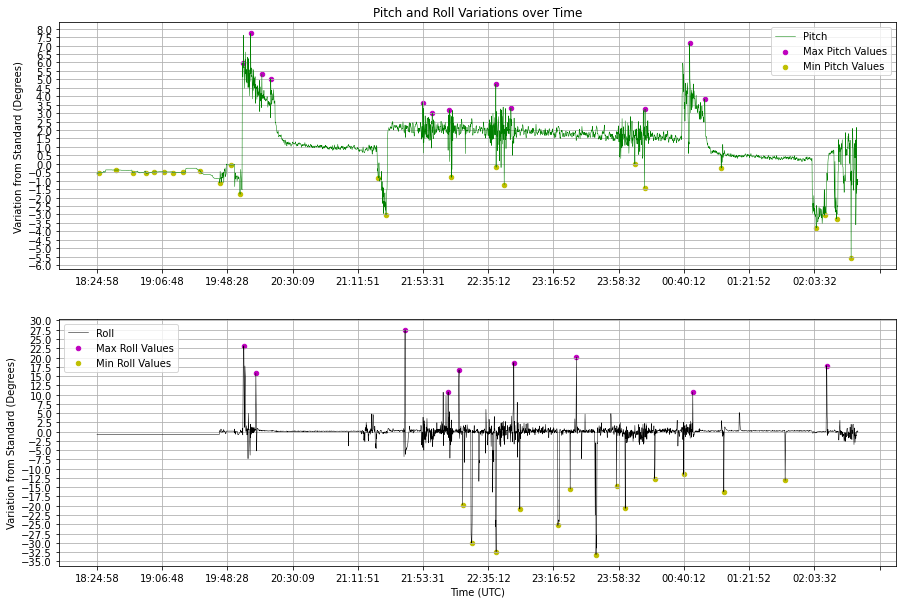

In [78]:
# plotting pitch and roll changes on top of each other to figure out turning points- labels are strings, not floats!

fig=plt.figure(1, figsize=(15, 10))

ax1 = plt.subplot( 211)
ax1.plot( str_time, pitch, label="Pitch", c='g', linewidth=.5)
ax1.scatter( str_peak_pos, height, label="Max Pitch Values", c='m', s=20)
ax1.scatter( str_min_pos, min_height, label="Min Pitch Values", c='y', s=20)

ax1.set_ylabel( "Variation from Standard (Degrees)")
ax1.set_title( 'Pitch and Roll Variations over Time')
ax1.xaxis.set_major_locator( plt.MaxNLocator( 15))
ax1.yaxis.set_major_locator( plt.MaxNLocator( 30))
plt.grid( 'on')
plt.legend()

ax2 = plt.subplot( 212)
ax2.plot( str_time, roll, label="Roll", c='k', linewidth=.5 )
ax2.scatter( str_rpeak_pos, rheight, label="Max Roll Values", c='m', s=20)
ax2.scatter( str_rmin_pos, rmin_height, label="Min Roll Values", c='y', s=20)

ax2.set_xlabel( "Time (UTC)")
ax2.set_ylabel( "Variation from Standard (Degrees)")
ax2.xaxis.set_major_locator( plt.MaxNLocator( 15))
ax2.yaxis.set_major_locator( plt.MaxNLocator( 30))

plt.grid( 'on')
plt.legend()

(21.500099182128906, 24.69985580444336)

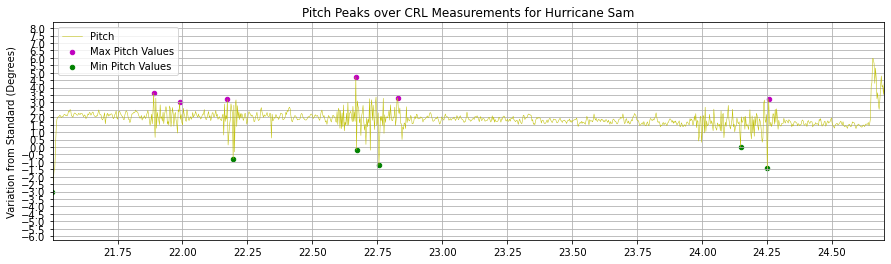

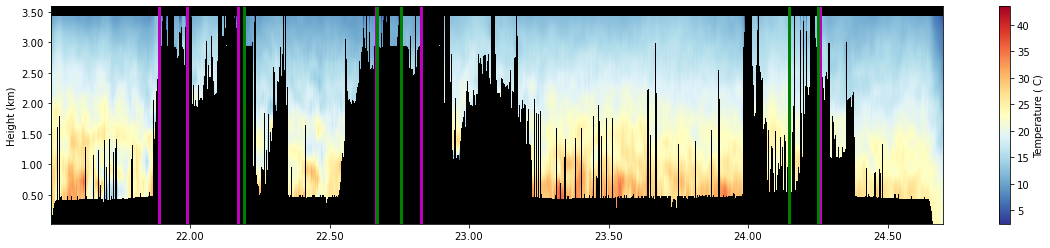

In [79]:
fig=plt.figure(1, figsize=(14.9, 4))

ax1 = plt.subplot( 111)
ax1.plot( float_time, pitch, label="Pitch", c='y', linewidth=.5)
ax1.scatter( float_peak_pos, height, label="Max Pitch Values", c='m', s=20)
ax1.scatter( float_min_pos, min_height, label="Min Pitch Values", c='g', s=20)

ax1.set_ylabel( "Variation from Standard (Degrees)")
ax1.xaxis.set_major_locator( plt.MaxNLocator( 15))
ax1.yaxis.set_major_locator( plt.MaxNLocator( 30))
plt.grid( 'on')
plt.legend()
plt.xlim( [crl_data.time[0], crl_data.time[-1] ]) # these limits line up with crl plot below
plt.title("Pitch Peaks over CRL Measurements for Hurricane Sam") # , 9/26/21")

# make lines on crl plots where min and max pitch values are found!
# sam 9/26, all crl data
plt.figure( figsize=(20, 4))
make_plots.plot_T( crl_path, crl_name, 0, len( crl_data.time) - 1, 'time')

for pitchx in float_peak_pos:
    plt.axvline( x = pitchx, c = 'm', label='Max Pitch', linewidth=3.0)
for pitchx in float_min_pos:
    plt.axvline( x = pitchx, c = 'g', label='Min Pitch', linewidth=3.0)
plt.grid(False)
plt.xlim( [crl_data.time[0], crl_data.time[-1] ])


(21.500099182128906, 24.69985580444336)

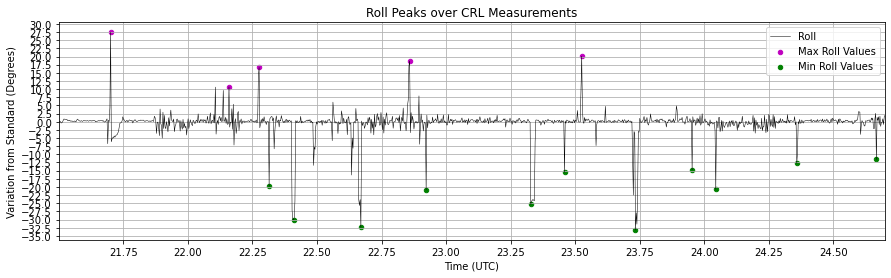

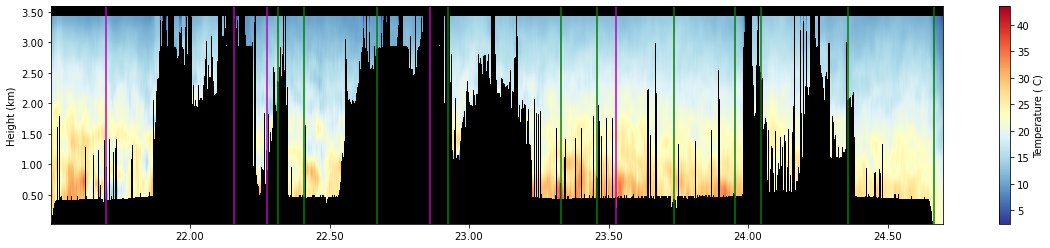

In [80]:
# the same plot as above but for roll
plt.figure( figsize=(14.8, 4))
plt.title("Roll Peaks over CRL Measurements") # , 9/26/21")

ax2 = plt.subplot( 111)
ax2.plot( float_time, roll, label="Roll", c='k', linewidth=.5 )
ax2.scatter( float_rpeak_pos, rheight, label="Max Roll Values", c='m', s=20)
ax2.scatter( float_rmin_pos, rmin_height, label="Min Roll Values", c='g', s=20)

ax2.set_xlabel( "Time (UTC)")
ax2.set_ylabel( "Variation from Standard (Degrees)")
ax2.xaxis.set_major_locator( plt.MaxNLocator( 15))
ax2.yaxis.set_major_locator( plt.MaxNLocator( 30))

plt.grid( 'on')
plt.legend()
plt.xlim( [crl_data.time[0], crl_data.time[-1] ])

plt.figure( figsize=(20, 4))
make_plots.plot_T( crl_path, crl_name, 0, len( crl_data.time) - 1, 'time')

for rollx in float_rpeak_pos:
    plt.axvline( x = rollx, c = 'm', label='Max Roll', linewidth=1.5)
for rollx in float_rmin_pos:
    plt.axvline( x = rollx, c = 'g', label='Min Roll', linewidth=1.5)
plt.grid( False)
plt.xlim( [crl_data.time[0], crl_data.time[-1] ])
